In [1]:
# %pip install --upgrade pingouin
%pip install pyvttbl


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.spatial import distance
from IPython.display import display
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
# import pyvttbl as pt
# OG_DATA_PATH = './TaskPerformance/'
OG_DATA_PATH = './MatData/'
PLOTS_PATH = './Sabine_poster/map/'
DATA_PATH = './AllData/'
PROCESSED_DATA_PATH = './csv_files/'
os.makedirs(os.path.dirname(PLOTS_PATH), exist_ok=True)
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
sns.set(context = "poster", style="white", palette="dark", font_scale=2, rc={'figure.figsize':(12,9)})

In [3]:
# Check valid subjects
subdf = pd.read_csv(DATA_PATH+'./Seahaven_alignment_project.csv', sep=',')

## Getting House angles and coordinates and saving in csv

In [4]:
housedf = pd.read_csv(DATA_PATH + 'complete_list_houses.txt',header=None) 
house_coords = pd.read_csv(DATA_PATH + 'HouseList.txt',header=None)
housedf.columns=['HouseNr_Angle']
house_coords.columns = ['HouseNr_coordinates']
housedf = housedf.HouseNr_Angle.str.split('_', expand=True)
housedf.columns=['HouseNr', 'Angle']
housedf.set_index('HouseNr', inplace=True)
house_coords = house_coords.HouseNr_coordinates.str.split(':', expand=True)
house_coords.columns = ['HouseNr', 'coordinates']
house_coords[['x','y']] = house_coords.coordinates.str.split(';', expand=True)
house_coords.set_index('HouseNr', inplace=True)

housedf = housedf.merge(house_coords, on='HouseNr')
housedf.drop(columns='coordinates', inplace=True)

housedf = housedf.reset_index()
housedf.HouseNr.str.strip()
housedf.Angle = housedf.Angle.str.strip().astype(np.float64)
housedf.x = housedf.x.str.strip().astype(np.float64)
housedf.y = housedf.y.str.strip().astype(np.float64)
# housedf = housedf.astype(np.float64)
display(housedf.info())

housedf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_house_info.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 4 columns):
HouseNr    193 non-null object
Angle      193 non-null float64
x          193 non-null float64
y          193 non-null float64
dtypes: float64(3), object(1)
memory usage: 6.2+ KB


None

# Finding valid subjects from map and VR groups
* ### Subjects who have finished 3 sessions
* ### Subjects who have not been discarded because of faulty measurement

In [5]:
maptmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "map"')
    [['Subject']] 
)
VRtmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "VR"')
    [['Subject']] 
)
map_val_subs = maptmpdf.Subject.unique()  
VR_val_subs = VRtmpdf.Subject.unique()
display(map_val_subs)
display(VR_val_subs)

array([4199, 8078, 8802, 8021, 9864, 2294, 7396, 2557, 5904, 2096, 1719,
       4749, 2299, 6449, 8124, 7844, 5048, 8479, 9369, 5162, 3426, 7085],
      dtype=int64)

array([9437, 1155, 8547, 8261, 3023, 7021, 5239, 8936, 9961, 9017, 1089,
       2044, 8195, 4272, 5346, 8072, 6398, 3743, 5253, 9475, 8954, 8699],
      dtype=int64)

# Reading Task performance data from .mat files

In [6]:
def mat_to_df(subNr,taskType):
    '''
    converts mat struct with task results into pandas df
    also adds extra column with information whether trial was correct or wrong    
    '''
    columns = {'Absolute': ['HouseNr', 'Correct_Angle', 'Wrong_Angle', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Relative': ['PrimeNr', 'TargetNr_correct', 'TargetNr_wrong', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Pointing': ['PrimeNr', 'TargetNr', 'Angle_correct', 'Angle_wrong','Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject']
              }
    matpath = OG_DATA_PATH+"/AlignmentVR_SubjNo_"+ str(subNr) +".mat"
    if os.path.exists(matpath):
        mat_contents = spio.loadmat(matpath)
        type_array = []
        for j,cond_2 in enumerate(["Trial_3s", "Trial_Inf"]):
            trials_array = []
            for line in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0])):
                value_array = []
                for column in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0])):
                    value = mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0][column][0][0]
                    value_array.append(value)
                # check if trial is correct(true or false
                value_array.append(value_array[-1] == value_array[-3])
                value_array.extend([cond_2.split('_')[1],taskType, subNr]) 
    #                 print(value_array)
                trials_array.append(value_array)
    #             print(len(value_array))
            type_array.extend(trials_array)
    #     print(type_array)
        return pd.DataFrame.from_records(type_array, columns=columns[taskType])
    else:
        print(matpath+' NOT FOUND!')
        return pd.DataFrame()

# Reading all Map data

In [7]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(map_val_subs)],
            ignore_index=True) 
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']
abs_df['AngularDiff'] = abs_df['AngularDiff'].astype(str)
abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
# display(abs_df.Correct_Angle_180.value_counts(bins=7))
# bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,15,45,75,105,135,165,195]
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)
abs_df['AngleToNorth'] = abs_df['AngleToNorth'].astype(str)

display(abs_df.AngleToNorth.value_counts())

150    286
90     264
60     264
30     242
120    242
180    154
0      132
Name: AngleToNorth, dtype: int64

In [8]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(map_val_subs)],
            ignore_index=True) 
housedf.HouseNr = housedf.HouseNr.astype(int)

rel_df['Correct_Angle'] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')['Angle']
rel_df['Wrong_Angle'] = rel_df.merge(housedf, left_on='TargetNr_wrong', right_on='HouseNr', how='left')['Angle']
rel_df[['target_x', 'target_y']] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')[['x','y']]
rel_df[['prime_x', 'prime_y']] = rel_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
rel_df['distance_prime_target'] = np.sqrt((rel_df.prime_x - rel_df.target_x)**2 + (rel_df.prime_y - rel_df.target_y)**2 )
rel_df['AngularDiff'] = abs(rel_df.Correct_Angle - rel_df.Wrong_Angle)
rel_df.loc[rel_df['AngularDiff']>180, 'AngularDiff' ] = 360 - rel_df['AngularDiff']

# bins = pd.IntervalIndex.from_tuples([(0, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,45,75,105,135,165,195]
rel_df['AngularDiff'] = pd.cut(rel_df.AngularDiff, bins=bins,labels=[30,60,90,120,150,180], retbins=False)

rel_df['AngularDiff'] = rel_df['AngularDiff'].astype(str)

display(rel_df.AngularDiff.value_counts())
display(rel_df.head())

90     264
30     264
150    264
60     264
180    264
120    264
Name: AngularDiff, dtype: int64

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,Correct_Angle,Wrong_Angle,target_x,target_y,prime_x,prime_y,distance_prime_target,AngularDiff
0,39,83,142,D,1.587644,U,False,3s,Relative,4199,180.0,210.0,659.8,841.0,647.9,876.3,37.251846,30
1,171,182,175,U,2.216276,D,False,3s,Relative,4199,63.0,237.0,610.8,777.6,316.8,824.3,297.685892,180
2,189,191,67,U,1.601913,U,True,3s,Relative,4199,60.0,270.0,222.6,827.6,213.6,866.2,39.635338,150
3,135,132,114,D,1.748102,U,False,3s,Relative,4199,120.0,305.0,573.6,881.9,439.3,657.3,261.689988,180
4,152,187,9,U,1.414193,U,True,3s,Relative,4199,240.0,180.0,432.4,631.7,525.3,717.4,126.391851,60


In [9]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(map_val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']
point_df['AngularDiff'] = point_df['AngularDiff'].astype(str)
point_df[['target_x', 'target_y']] = point_df.merge(housedf, left_on='TargetNr', right_on='HouseNr', how='left')[['x','y']]
point_df[['prime_x', 'prime_y']] = point_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
point_df['distance_prime_target'] = np.sqrt((point_df.prime_x - point_df.target_x)**2 + 
                                            (point_df.prime_y - point_df.target_y)**2 )

display(point_df.head())

,PrimeNr,TargetNr,Angle_correct,Angle_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,target_x,target_y,prime_x,prime_y,distance_prime_target
0,180,72,273,93,D,1.813603,D,True,3s,Pointing,4199,180,284.2,841.5,522.0,830.2,238.068331
1,15,132,203,173,U,2.345135,U,True,3s,Pointing,4199,30,573.6,881.9,397.9,749.6,219.940401
2,133,65,226,16,U,1.916309,D,False,3s,Pointing,4199,150,437.4,671.2,597.1,827.9,223.738642
3,156,67,306,126,D,2.168773,U,False,3s,Pointing,4199,180,290.0,783.1,462.5,656.6,213.912365
4,33,9,243,213,D,2.099210,D,True,3s,Pointing,4199,30,541.8,795.2,495.2,885.6,101.704081


In [10]:
north_alignment_map = (
    abs_df
    .groupby(['Subject','AngleToNorth','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
)
north_alignment_map['Group'] = 'map'
display(north_alignment_map)

df = pd.pivot_table(north_alignment_map, index=['Subject','Group'], values='Accuracy',columns=['AngleToNorth','Time'],
                    aggfunc='mean')
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_angletonorth_accuracy_time_wideform.csv', index=False)

,Subject,AngleToNorth,Time,Accuracy,Group
0,1719,0,3s,0.750000,map
1,1719,0,Inf,0.500000,map
2,1719,120,3s,0.250000,map
3,1719,120,Inf,0.428571,map
4,1719,150,3s,0.000000,map
...,...,...,...,...,...
303,9864,30,Inf,0.800000,map
304,9864,60,3s,0.857143,map
305,9864,60,Inf,0.400000,map
306,9864,90,3s,0.500000,map


MultiIndex([(  '0',  '3s'),
            (  '0', 'Inf'),
            ('120',  '3s'),
            ('120', 'Inf'),
            ('150',  '3s'),
            ('150', 'Inf'),
            ('180',  '3s'),
            ('180', 'Inf'),
            ( '30',  '3s'),
            ( '30', 'Inf'),
            ( '60',  '3s'),
            ( '60', 'Inf'),
            ( '90',  '3s'),
            ( '90', 'Inf')],
           names=['AngleToNorth', 'Time'])

Index(['0_3s', '0_Inf', '120_3s', '120_Inf', '150_3s', '150_Inf', '180_3s',
       '180_Inf', '30_3s', '30_Inf', '60_3s', '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [11]:
map_perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
map_perf_df['Group'] = 'Map'
display(map_perf_df.head())

,Subject,Task,Time,Accuracy,Group
0,1719,Absolute,3s,0.500000,Map
1,1719,Absolute,Inf,0.611111,Map
2,2096,Absolute,3s,0.527778,Map
3,2096,Absolute,Inf,0.611111,Map
4,2294,Absolute,3s,0.555556,Map


In [12]:
map_angdiff_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
map_angdiff_df['Group'] = 'map'
display(map_angdiff_df)

,Subject,Task,Time,AngularDiff,Accuracy,Group
0,1719,Absolute,3s,120,0.666667,map
1,1719,Absolute,3s,150,0.166667,map
2,1719,Absolute,3s,180,0.666667,map
3,1719,Absolute,3s,30,0.666667,map
4,1719,Absolute,3s,60,0.500000,map
...,...,...,...,...,...,...
259,9864,Pointing,Inf,150,0.500000,map
260,9864,Pointing,Inf,180,0.333333,map
261,9864,Pointing,Inf,30,0.500000,map
262,9864,Pointing,Inf,60,0.500000,map


In [13]:
tmpdf = pd.concat([
    (
    rel_df
    .groupby(['Task','Time','PrimeNr','TargetNr_correct', 'distance_prime_target'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Task','Time','PrimeNr','TargetNr','distance_prime_target'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
    
])
tmpdf['Group'] = 'map'
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_rel_point_distance_accuracy.csv', index=False)

display(tmpdf)

C:\Users\akeshava\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,Accuracy,PrimeNr,TargetNr,TargetNr_correct,Task,Time,distance_prime_target,Group
0,0.681818,15,NaN,18.0,Relative,3s,31.740353,map
1,0.772727,15,NaN,36.0,Relative,3s,158.913089,map
2,0.681818,33,NaN,38.0,Relative,3s,60.406705,map
3,0.772727,33,NaN,73.0,Relative,3s,69.766539,map
4,0.681818,39,NaN,40.0,Relative,3s,91.731401,map
...,...,...,...,...,...,...,...,...
67,0.681818,180,70.0,NaN,Pointing,Inf,80.795297,map
68,0.500000,189,32.0,NaN,Pointing,Inf,169.249077,map
69,0.590909,189,191.0,NaN,Pointing,Inf,39.635338,map
70,0.409091,193,11.0,NaN,Pointing,Inf,161.044621,map


# Reading all VR data

In [14]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(VR_val_subs)],
            ignore_index=True) 
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']
abs_df['AngularDiff'] = abs_df['AngularDiff'].astype(str)
abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
# display(abs_df.Correct_Angle_180.value_counts(bins=7))
# bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,15,45,75,105,135,165,195]
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)
abs_df['AngleToNorth'] = abs_df['AngleToNorth'].astype(str)
display(abs_df.AngleToNorth.value_counts())

150    286
90     264
60     264
30     242
120    242
180    154
0      132
Name: AngleToNorth, dtype: int64

In [15]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(VR_val_subs)],
            ignore_index=True) 

rel_df['Correct_Angle'] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')['Angle']
rel_df['Wrong_Angle'] = rel_df.merge(housedf, left_on='TargetNr_wrong', right_on='HouseNr', how='left')['Angle']
rel_df[['target_x', 'target_y']] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')[['x','y']]
rel_df[['prime_x', 'prime_y']] = rel_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
rel_df['distance_prime_target'] = np.sqrt((rel_df.prime_x - rel_df.target_x)**2 + (rel_df.prime_y - rel_df.target_y)**2 )
rel_df['AngularDiff'] = abs(rel_df.Correct_Angle - rel_df.Wrong_Angle)
rel_df.loc[rel_df['AngularDiff']>180, 'AngularDiff' ] = 360 - rel_df['AngularDiff']

# bins = pd.IntervalIndex.from_tuples([(0, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,45,75,105,135,165,195]
rel_df['AngularDiff'] = pd.cut(rel_df.AngularDiff, bins=bins,labels=[30,60,90,120,150,180], retbins=False)

rel_df['AngularDiff'] = rel_df['AngularDiff'].astype(str)

display(rel_df.AngularDiff.value_counts())
display(rel_df.head())

90     264
30     264
150    264
60     264
180    264
120    264
Name: AngularDiff, dtype: int64

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,Correct_Angle,Wrong_Angle,target_x,target_y,prime_x,prime_y,distance_prime_target,AngularDiff
0,15,18,137,D,1.867401,D,True,3s,Relative,9437,0.0,120.0,399.5,717.9,397.9,749.6,31.740353,120
1,180,169,125,D,1.342990,U,False,3s,Relative,9437,325.0,125.0,349.0,813.9,522.0,830.2,173.766193,150
2,76,72,197,U,1.036450,D,False,3s,Relative,9437,270.0,60.0,284.2,841.5,380.3,794.5,106.977614,150
3,119,121,108,U,1.488077,U,True,3s,Relative,9437,207.0,30.0,473.7,818.6,412.0,779.9,72.832548,180
4,15,36,195,U,1.045882,D,False,3s,Relative,9437,0.0,148.0,437.5,903.5,397.9,749.6,158.913089,150


In [16]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(VR_val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']
point_df['AngularDiff'] = point_df['AngularDiff'].astype(str)
point_df[['target_x', 'target_y']] = point_df.merge(housedf, left_on='TargetNr', right_on='HouseNr', how='left')[['x','y']]
point_df[['prime_x', 'prime_y']] = point_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
point_df['distance_prime_target'] = np.sqrt((point_df.prime_x - point_df.target_x)**2 + 
                                            (point_df.prime_y - point_df.target_y)**2 )

display(point_df.head())

,PrimeNr,TargetNr,Angle_correct,Angle_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,target_x,target_y,prime_x,prime_y,distance_prime_target
0,81,79,49,289,U,1.039359,U,True,3s,Pointing,9437,120,287.0,817.8,439.8,950.2,202.182096
1,113,47,205,265,D,0.858058,D,True,3s,Pointing,9437,60,198.7,826.2,494.3,704.6,319.634041
2,189,136,239,329,U,0.808237,U,True,3s,Pointing,9437,90,601.8,864.3,213.6,866.2,388.204650
3,152,100,294,204,D,1.057500,D,True,3s,Pointing,9437,90,242.2,845.5,525.3,717.4,310.733358
4,180,72,273,93,D,0.715985,U,False,3s,Pointing,9437,180,284.2,841.5,522.0,830.2,238.068331


In [17]:
north_alignment_VR = (
    abs_df
    .groupby(['Subject','AngleToNorth','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
)
north_alignment_VR['Group'] = 'VR'
display(north_alignment_VR)
df = pd.pivot_table(north_alignment_VR, index=['Subject','Group'], values='Accuracy',columns=['AngleToNorth','Time'],
                    aggfunc='mean').reset_index()
display(df.head())
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_VR_angletonorth_accuracy_time_wideform.csv', index=False)

,Subject,AngleToNorth,Time,Accuracy,Group
0,1089,0,3s,0.250000,VR
1,1089,0,Inf,0.000000,VR
2,1089,120,3s,0.500000,VR
3,1089,120,Inf,0.142857,VR
4,1089,150,3s,0.500000,VR
...,...,...,...,...,...
303,9961,30,Inf,0.800000,VR
304,9961,60,3s,0.285714,VR
305,9961,60,Inf,0.200000,VR
306,9961,90,3s,0.500000,VR


AngleToNorth Subject Group     0        120                 150            \
Time                          3s  Inf    3s       Inf        3s       Inf   
0               1089    VR  0.25  0.0  0.50  0.142857  0.500000  0.571429   
1               1155    VR  0.25  0.0  0.25  0.285714  0.333333  0.714286   
2               2044    VR  0.50  0.0  0.75  0.428571  0.500000  0.142857   
3               3023    VR  0.50  1.0  1.00  0.571429  0.333333  1.000000   
4               3743    VR  0.75  1.0  0.50  0.714286  0.166667  0.857143   

AngleToNorth       180              30             60             90            
Time                3s   Inf        3s  Inf        3s  Inf        3s       Inf  
0             0.333333  0.50  0.333333  0.6  0.285714  0.6  0.666667  0.666667  
1             0.333333  0.50  0.666667  0.6  0.428571  0.6  0.833333  0.500000  
2             0.333333  0.25  0.500000  0.6  0.428571  0.6  0.166667  0.666667  
3             1.000000  0.50  1.000000  0.8  0.571429  0.6  0.500000  0.833333  
4             0.333333  1.00  0.500000  0.8  0.285714  0.4  0.666667  0.833333

Index(['Subject', 'Group', '0_3s', '0_Inf', '120_3s', '120_Inf', '150_3s',
       '150_Inf', '180_3s', '180_Inf', '30_3s', '30_Inf', '60_3s', '60_Inf',
       '90_3s', '90_Inf'],
      dtype='object')

In [18]:
VR_perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
VR_perf_df['Group'] = 'VR'
# display(VR_perf_df.isna().sum())
display(VR_perf_df)

,Subject,Task,Time,Accuracy,Group
0,1089,Absolute,3s,0.416667,VR
1,1089,Absolute,Inf,0.472222,VR
2,1155,Absolute,3s,0.472222,VR
3,1155,Absolute,Inf,0.500000,VR
4,2044,Absolute,3s,0.444444,VR
...,...,...,...,...,...
39,9437,Pointing,Inf,0.611111,VR
40,9475,Pointing,3s,0.472222,VR
41,9475,Pointing,Inf,0.583333,VR
42,9961,Pointing,3s,0.416667,VR


In [19]:
all_data = pd.concat([map_perf_df,VR_perf_df])
display(all_data.isna().sum())
all_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_group_task_time_accuracy.csv', index=False)

# pd.melt(all_data,id_vars=['Subject','Group'],value_vars=[])
df = pd.pivot_table(all_data, index=['Subject','Group'], values='Accuracy',columns=['Task','Time']).reset_index()
display(df.isna().sum())
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.isna().sum())
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_group_task_time_accuracy_wideform.csv', index=False)

Subject     0
Task        0
Time        0
Accuracy    0
Group       0
dtype: int64

Task      Time
Subject           0
Group             0
Absolute  3s      0
          Inf     0
Pointing  3s      0
          Inf     0
Relative  3s      0
          Inf     0
dtype: int64

Subject         0
Group           0
Absolute_3s     0
Absolute_Inf    0
Pointing_3s     0
Pointing_Inf    0
Relative_3s     0
Relative_Inf    0
dtype: int64

In [20]:
VR_angdiff_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
VR_angdiff_df['Group'] = 'VR'
display(VR_angdiff_df)

,Subject,Task,Time,AngularDiff,Accuracy,Group
0,1089,Absolute,3s,120,0.500000,VR
1,1089,Absolute,3s,150,0.166667,VR
2,1089,Absolute,3s,180,0.166667,VR
3,1089,Absolute,3s,30,0.833333,VR
4,1089,Absolute,3s,60,0.500000,VR
...,...,...,...,...,...,...
259,9961,Pointing,Inf,150,0.833333,VR
260,9961,Pointing,Inf,180,0.500000,VR
261,9961,Pointing,Inf,30,0.833333,VR
262,9961,Pointing,Inf,60,0.500000,VR


In [21]:
tmpdf = pd.concat([
    (
    rel_df
    .groupby(['Task','Time','PrimeNr','TargetNr_correct', 'distance_prime_target'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Task','Time','PrimeNr','TargetNr','distance_prime_target'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
    
])
tmpdf['Group'] = 'VR'
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_VR_rel_point_distance_accuracy.csv', index=False)

display(tmpdf)

C:\Users\akeshava\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,Accuracy,PrimeNr,TargetNr,TargetNr_correct,Task,Time,distance_prime_target,Group
0,0.454545,15,NaN,18.0,Relative,3s,31.740353,VR
1,0.590909,15,NaN,36.0,Relative,3s,158.913089,VR
2,0.545455,33,NaN,38.0,Relative,3s,60.406705,VR
3,0.681818,33,NaN,73.0,Relative,3s,69.766539,VR
4,0.454545,39,NaN,40.0,Relative,3s,91.731401,VR
...,...,...,...,...,...,...,...,...
67,0.454545,180,70.0,NaN,Pointing,Inf,80.795297,VR
68,0.636364,189,32.0,NaN,Pointing,Inf,169.249077,VR
69,0.863636,189,191.0,NaN,Pointing,Inf,39.635338,VR
70,0.454545,193,11.0,NaN,Pointing,Inf,161.044621,VR


In [22]:
all_angdiff_data = pd.concat([map_angdiff_df,VR_angdiff_df])
display(all_angdiff_data)
all_angdiff_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_group_angulardifference_time_accuracy.csv', index=False)
df = pd.pivot_table(all_angdiff_data, index=['Subject','Group'], values='Accuracy',columns=['AngularDiff','Time'],
                    aggfunc='mean').reset_index()
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_group_angulardifference_time_accuracy_wideform.csv', index=False)

,Subject,Task,Time,AngularDiff,Accuracy,Group
0,1719,Absolute,3s,120,0.666667,map
1,1719,Absolute,3s,150,0.166667,map
2,1719,Absolute,3s,180,0.666667,map
3,1719,Absolute,3s,30,0.666667,map
4,1719,Absolute,3s,60,0.500000,map
...,...,...,...,...,...,...
259,9961,Pointing,Inf,150,0.833333,VR
260,9961,Pointing,Inf,180,0.500000,VR
261,9961,Pointing,Inf,30,0.833333,VR
262,9961,Pointing,Inf,60,0.500000,VR


MultiIndex([('Subject',    ''),
            (  'Group',    ''),
            (    '120',  '3s'),
            (    '120', 'Inf'),
            (    '150',  '3s'),
            (    '150', 'Inf'),
            (    '180',  '3s'),
            (    '180', 'Inf'),
            (     '30',  '3s'),
            (     '30', 'Inf'),
            (     '60',  '3s'),
            (     '60', 'Inf'),
            (     '90',  '3s'),
            (     '90', 'Inf')],
           names=['AngularDiff', 'Time'])

Index(['Subject', 'Group', '120_3s', '120_Inf', '150_3s', '150_Inf', '180_3s',
       '180_Inf', '30_3s', '30_Inf', '60_3s', '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [23]:
north_alignment = pd.concat([north_alignment_map,north_alignment_VR])
display(north_alignment)
north_alignment.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_group_angletonorth_time_accuracy.csv', index=False)

df = pd.pivot_table(north_alignment, index=['Group','Subject'], values='Accuracy',columns=['AngleToNorth','Time'],
                    aggfunc='mean').reset_index()
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_group_angletonorth_time_accuracy_wideform.csv', index=False)

,Subject,AngleToNorth,Time,Accuracy,Group
0,1719,0,3s,0.750000,map
1,1719,0,Inf,0.500000,map
2,1719,120,3s,0.250000,map
3,1719,120,Inf,0.428571,map
4,1719,150,3s,0.000000,map
...,...,...,...,...,...
303,9961,30,Inf,0.800000,VR
304,9961,60,3s,0.285714,VR
305,9961,60,Inf,0.200000,VR
306,9961,90,3s,0.500000,VR


MultiIndex([(  'Group',    ''),
            ('Subject',    ''),
            (      '0',  '3s'),
            (      '0', 'Inf'),
            (    '120',  '3s'),
            (    '120', 'Inf'),
            (    '150',  '3s'),
            (    '150', 'Inf'),
            (    '180',  '3s'),
            (    '180', 'Inf'),
            (     '30',  '3s'),
            (     '30', 'Inf'),
            (     '60',  '3s'),
            (     '60', 'Inf'),
            (     '90',  '3s'),
            (     '90', 'Inf')],
           names=['AngleToNorth', 'Time'])

Index(['Group', 'Subject', '0_3s', '0_Inf', '120_3s', '120_Inf', '150_3s',
       '150_Inf', '180_3s', '180_Inf', '30_3s', '30_Inf', '60_3s', '60_Inf',
       '90_3s', '90_Inf'],
      dtype='object')

In [24]:
rel_df.columns

Index(['PrimeNr', 'TargetNr_correct', 'TargetNr_wrong', 'Correct_Answer', 'RT',
       'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject', 'Correct_Angle',
       'Wrong_Angle', 'target_x', 'target_y', 'prime_x', 'prime_y',
       'distance_prime_target', 'AngularDiff'],
      dtype='object')

# Get subject numbers for all 3 measurements

### Get subject indices and merge with FRS scales to join map task accuracy and FRS score in one df

In [25]:
FRS_map = pd.read_csv(DATA_PATH + 'FRS_scales_Map.csv', sep=',', na_values=' ') 
display(FRS_map.info())
FRS_map.columns = ['VP', 'Gender','Age', 'Egocentric','Allocentric','Cardinal Direction']
FRS_map.VP = FRS_map.VP.astype(str)
FRS_map_long = pd.melt(FRS_map, id_vars=['VP'], value_vars=['Egocentric','Allocentric','Cardinal Direction'],
                     var_name='Scale',value_name='Score')
display(FRS_map.info())
tmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "map"')
    [['Subject','Comments']]
)
tmpdf.Subject = tmpdf.Subject.astype(str)
tmpdf = tmpdf.set_index('Subject')

display(tmpdf.info())
tmpdf[['measurement_1','measurement_2']] = tmpdf.Comments.str.replace(r'[A-Za-z\s\-\&\.\']','')\
                                                .str.strip()\
                                                .str.extract('\#([0-9]*)\#([0-9]*)', expand = True)
display(tmpdf.head())
tmpdf.drop(columns='Comments', inplace=True)
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_repeated_measurement_subID.csv')

map_perf_df.Subject = map_perf_df.Subject.astype(str)
map_measurements = map_perf_df.merge(tmpdf, on='Subject')
# map_measurements.
map_FRS_long = map_measurements.merge(FRS_map_long,left_on='measurement_1', right_on='VP')
display(map_FRS_long)
map_FRS_long.drop(columns=['VP'], inplace=True)
map_FRS_long.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_task_time_FRS_long.csv', index=False)

pivot_map = pd.pivot_table(map_perf_df, 
                   index=['Subject','Group'], 
                   values='Accuracy',
                   columns=['Task','Time'],
                   aggfunc='mean').reset_index()
pivot_map.Subject = pivot_map.Subject.astype(str)
pivot_map.columns = ['_'.join(col).rstrip('_') for col in pivot_map.columns.values]
tmpdf = tmpdf.merge(pivot_map, on='Subject')

tmpdf = tmpdf.merge(FRS_map, left_on='measurement_1', right_on='VP')
tmpdf.drop(columns=['VP'], inplace=True)
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_task_time_FRS_wideform.csv', index=False)
# display(tmpdf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
VP             22 non-null int64
Gender         22 non-null object
age            22 non-null int64
Scale1final    22 non-null float64
Scale2final    22 non-null float64
Scale3final    22 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
VP                    22 non-null object
Gender                22 non-null object
Age                   22 non-null int64
Egocentric            22 non-null float64
Allocentric           22 non-null float64
Cardinal Direction    22 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 4199 to 7085
Data columns (total 1 columns):
Comments    22 non-null object
dtypes: object(1)
memory usage: 352.0+ bytes


None

,Comments,measurement_1,measurement_2
Subject,,,
4199,third training - #4608 & #3422,4608,3422
8078,third training - #4875 & #4477,4875,4477
8802,third training - #2650 & #9400 firefox map cr...,2650,9400
8021,third training - #6506 & #1385\n,6506,1385
9864,third training - #1216 & #8357,1216,8357


,Subject,Task,Time,Accuracy,Group,measurement_1,measurement_2,VP,Scale,Score
0,1719,Absolute,3s,0.500000,Map,4051,3005,4051,Egocentric,2.50
1,1719,Absolute,3s,0.500000,Map,4051,3005,4051,Allocentric,3.86
2,1719,Absolute,3s,0.500000,Map,4051,3005,4051,Cardinal Direction,1.00
3,1719,Absolute,Inf,0.611111,Map,4051,3005,4051,Egocentric,2.50
4,1719,Absolute,Inf,0.611111,Map,4051,3005,4051,Allocentric,3.86
...,...,...,...,...,...,...,...,...,...,...
301,9369,Pointing,3s,0.333333,Map,1379,2698,1379,Allocentric,2.60
302,9369,Pointing,3s,0.333333,Map,1379,2698,1379,Cardinal Direction,3.50
303,9369,Pointing,Inf,0.500000,Map,1379,2698,1379,Egocentric,2.40
304,9369,Pointing,Inf,0.500000,Map,1379,2698,1379,Allocentric,2.60


### Get subject indices and merge with FRS scales to join VR task accuracy and FRS score in one df

In [26]:
FRS_VR = pd.read_csv(DATA_PATH + 'FRS_scales_VR.csv', sep=';', na_values=' ') 
FRS_VR.columns = ['VP', 'Gender','Age', 'Egocentric','Allocentric','Cardinal Direction']
FRS_VR.VP = FRS_VR.VP.astype(str)
FRS_VR_long = pd.melt(FRS_VR, id_vars=['VP'], value_vars=['Egocentric','Allocentric','Cardinal Direction'],
                     var_name='Scale',value_name='Score')

display(FRS_VR.info())
tmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "VR"')
    [['Subject','Comments']]
)
tmpdf.Subject = tmpdf.Subject.astype(str)
tmpdf = tmpdf.set_index('Subject')

display(tmpdf.info())
tmpdf[['measurement_1','measurement_2']] = tmpdf.Comments.str.replace(r'[A-Za-z\s\-\&\.\']','')\
                                                .str.strip()\
                                                .str.extract('\#([0-9]*)\#([0-9]*)', expand = True)
tmpdf.drop(columns='Comments', inplace=True)
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_VR_repeated_measurement_subID.csv')
display(tmpdf.head())
VR_perf_df.Subject = VR_perf_df.Subject.astype(str)
VR_measurements = VR_perf_df.merge(tmpdf, on='Subject')
VR_FRS_task_long = VR_measurements.merge(FRS_VR_long,left_on='measurement_1', right_on='VP')
display(VR_FRS_task_long)
VR_FRS_task_long.drop(columns=['VP'], inplace=True)
VR_FRS_task_long.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_VR_task_time_FRS_long.csv', index=False)

pivot_VR = pd.pivot_table(VR_perf_df, 
                   index=['Subject','Group'], 
                   values='Accuracy',
                   columns=['Task','Time'],
                   aggfunc='mean').reset_index()
pivot_VR.Subject = pivot_VR.Subject.astype(str)
pivot_VR.columns = ['_'.join(col).rstrip('_') for col in pivot_VR.columns.values]
tmpdf = tmpdf.merge(pivot_VR, on='Subject')

tmpdf = tmpdf.merge(FRS_VR, left_on='measurement_1', right_on='VP')
tmpdf.drop(columns=['VP'], inplace=True)
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_VR_task_time_FRS_wideform.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
VP                    22 non-null object
Gender                22 non-null object
Age                   22 non-null int64
Egocentric            19 non-null float64
Allocentric           19 non-null float64
Cardinal Direction    19 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 9437 to 8699
Data columns (total 1 columns):
Comments    22 non-null object
dtypes: object(1)
memory usage: 352.0+ bytes


None

,measurement_1,measurement_2
Subject,,
9437,1909,8551
1155,3668,1540
8547,8466,8041
8261,3430,3963
3023,6348,5696


,Subject,Task,Time,Accuracy,Group,measurement_1,measurement_2,VP,Scale,Score
0,1155,Absolute,3s,0.472222,VR,3668,1540,3668,Egocentric,6.60
1,1155,Absolute,3s,0.472222,VR,3668,1540,3668,Allocentric,6.71
2,1155,Absolute,3s,0.472222,VR,3668,1540,3668,Cardinal Direction,4.00
3,1155,Absolute,Inf,0.500000,VR,3668,1540,3668,Egocentric,6.60
4,1155,Absolute,Inf,0.500000,VR,3668,1540,3668,Allocentric,6.71
...,...,...,...,...,...,...,...,...,...,...
373,9961,Pointing,3s,0.416667,VR,8258,9176,8258,Allocentric,1.71
374,9961,Pointing,3s,0.416667,VR,8258,9176,8258,Cardinal Direction,3.00
375,9961,Pointing,Inf,0.611111,VR,8258,9176,8258,Egocentric,3.80
376,9961,Pointing,Inf,0.611111,VR,8258,9176,8258,Allocentric,1.71


In [27]:
tmpdf = ( north_alignment
         .groupby(['Group','Subject','AngleToNorth','Time'])
#          ['Subject']
         .agg('count')
         .rename(columns={'Accuracy':'Nr Observations'})
         .reset_index()         
)
display(tmpdf)

,Group,Subject,AngleToNorth,Time,Nr Observations
0,VR,1089,0,3s,1
1,VR,1089,0,Inf,1
2,VR,1089,120,3s,1
3,VR,1089,120,Inf,1
4,VR,1089,150,3s,1
...,...,...,...,...,...
611,map,9864,30,Inf,1
612,map,9864,60,3s,1
613,map,9864,60,Inf,1
614,map,9864,90,3s,1


In [28]:
map_anova_res = AnovaRM(map_perf_df,'Accuracy','Subject', within=['Task','Time']).fit()
print(map_anova_res.summary())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Task       6.3538 2.0000 42.0000 0.0039
Time      11.9633 1.0000 21.0000 0.0023
Task:Time  2.3703 2.0000 42.0000 0.1058



In [29]:
VR_anova_res = AnovaRM(VR_perf_df,'Accuracy','Subject', within=['Task','Time']).fit()
print(VR_anova_res)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Task       1.9049 2.0000 42.0000 0.1615
Time      16.4330 1.0000 21.0000 0.0006
Task:Time  0.3109 2.0000 42.0000 0.7345



In [30]:
anova_group = pg.mixed_anova(dv='Accuracy',within='Task',subject='Subject', between='Group', data=all_data) 
pg.print_table(anova_group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        0.019      1     42  0.019  1.107    0.299  0.026  -
Task         0.006      2     84  0.003  0.722    0.489  0.017  0.979
Interaction  0.063      2     84  0.031  7.560    0.001  0.153  -



In [31]:
post_hoc = pg.pairwise_ttests(dv='Accuracy', within='Task', between='Group', subject='Subject',
                   data=all_data, padjust='fdr_bh')
pg.print_table(post_hoc)


POST HOC TESTS

Contrast      Task      A         B         Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
------------  --------  --------  --------  --------  ------------  ------  -------  ---------  -------  --------  ----------  ------  --------
Task          -         Absolute  Relative  True      True          -0.352   87.000  two-sided    0.725     0.725  fdr_bh       0.125    -0.037
Task          -         Absolute  Pointing  True      True           0.753   87.000  two-sided    0.453     0.680  fdr_bh       0.155     0.096
Task          -         Relative  Pointing  True      True           1.071   87.000  two-sided    0.287     0.680  fdr_bh       0.205     0.140
Group         -         Map       VR        False     True           1.640  262.000  two-sided    0.102   nan      nan          0.482     0.201
Task * Group  Absolute  Map       VR        False     True           1.227   86.000  two-sided    0.223     0.223  fdr_

In [32]:
post_hoc = pg.pairwise_ttests(dv='Accuracy', within='Time', between='Group', subject='Subject',
                   data=all_data, padjust='bonf')
pg.print_table(post_hoc)


POST HOC TESTS

Contrast      Time    A    B    Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust         BF10    hedges
------------  ------  ---  ---  --------  ------------  ------  -------  ---------  -------  --------  ----------  ---------  --------
Time          -       3s   Inf  True      True          -5.404  131.000  two-sided    0.000   nan      nan         40030.000    -0.537
Group         -       Map  VR   False     True           1.640  262.000  two-sided    0.102   nan      nan             0.482     0.201
Time * Group  3s      Map  VR   False     True           1.759  130.000  two-sided    0.081     0.162  bonf            0.756     0.304
Time * Group  Inf     Map  VR   False     True           0.753  130.000  two-sided    0.453     0.906  bonf            0.241     0.130



In [33]:
map_angdiff_res = AnovaRM(map_angdiff_df,'Accuracy','Subject', within=['AngularDiff','Time'], aggregate_func='mean').fit()
print(map_angdiff_res.summary())

                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
AngularDiff       1.6574 5.0000 105.0000 0.1514
Time             11.9633 1.0000  21.0000 0.0023
AngularDiff:Time  3.0632 5.0000 105.0000 0.0127



In [34]:
VR_angdiff_res = AnovaRM(VR_angdiff_df,'Accuracy','Subject', within=['AngularDiff','Time'], aggregate_func='mean').fit()
print(VR_angdiff_res.summary())

                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
AngularDiff       2.6768 5.0000 105.0000 0.0256
Time             16.4330 1.0000  21.0000 0.0006
AngularDiff:Time  1.5526 5.0000 105.0000 0.1800



In [35]:
tmpdf = all_angdiff_data.query('Time == "Inf" ')
angdiff_anova_group = pg.mixed_anova(dv='Accuracy',within='AngularDiff',subject='Subject', between='Group', data=tmpdf) 
pg.print_table(angdiff_anova_group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        0.018      1     42  0.018  0.303    0.585  0.007  -
AngularDiff  0.175      5    210  0.035  3.027    0.012  0.067  0.914
Interaction  0.046      5    210  0.009  0.794    0.555  0.019  -



,Group,Task,Time,Subject,Accuracy [%]
0,Map,Absolute,3s,1719,0.500000
1,Map,Absolute,3s,2096,0.527778
2,Map,Absolute,3s,2294,0.555556
3,Map,Absolute,3s,2299,0.416667
4,Map,Absolute,3s,2557,0.472222
...,...,...,...,...,...
259,VR,Relative,Inf,8954,0.611111
260,VR,Relative,Inf,9017,0.666667
261,VR,Relative,Inf,9437,0.333333
262,VR,Relative,Inf,9475,0.527778


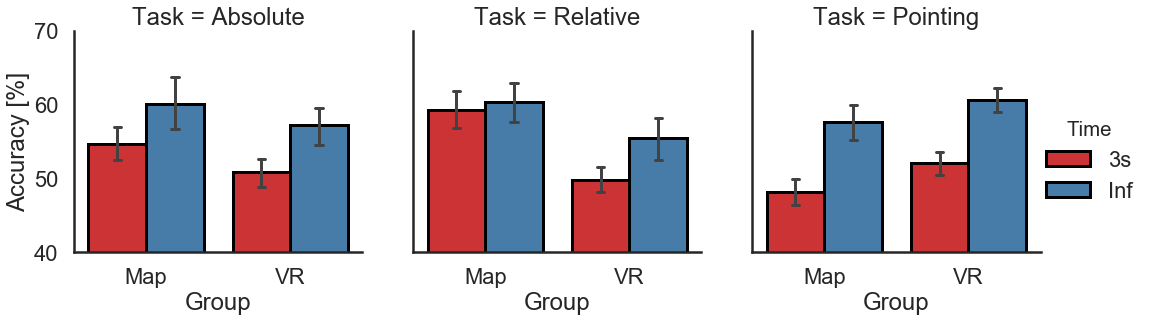

In [36]:
tmpdf = (
    all_data
    .groupby(['Group','Task','Time', 'Subject'])
    .agg({'Accuracy':'mean'})
    .rename(columns={'Accuracy':'Accuracy [%]'})
    .reset_index()
#     .query('Time == "Inf"')
)

display(tmpdf)
sns.set(context = "poster", style="white", palette="Set1", font_scale=1, rc={'figure.figsize':(16,12), "font.family": "sans serif" })
tmpdf['Accuracy [%]'] = tmpdf['Accuracy [%]']*100
# tmpdf['AngularDiff'] = tmpdf['AngularDiff'].astype(int)
# _, ax = plt.subplots(figsize=(16,12))
ax = sns.catplot(data=tmpdf, x='Group', y='Accuracy [%]',hue='Time',col='Task', kind='bar', ci=68,
            capsize=0.05, col_order=['Absolute','Relative','Pointing'],
            edgecolor=(0,0,0),errwidth=3,linewidth=3,
           )
# sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# ax.axhline(50, ls=':', color='k', lw=4)
# ax.set_ylabel('Accuracy [%]')
# ax.set_xlabel('Alignment To North [$^\circ$]')
ax.set(ylim=(40,70))
# ax.legend(title='', loc='upper right', fontsize=25)
plt.savefig(PLOTS_PATH+'/group_task_time_accuracy.png', quality=90)